# Take - Home  Challenge

A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day
that  a  user  logged  into  the  product.
Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .
We  suggest  spending  1­2  hours  on  this,  but  you're  welcome  to  spend  more  or  less.
Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better  ­­  no  more
than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help
us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation
you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data
you  think  would  be  valuable.

## Relax Inc. Take-Home Challenge


The  data  is  available  as  two  attached  CSV  files:

takehome_user_engagement. csv

takehome_users . csv

The  data  has  the  following  two  tables:

1]  A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the product  in  the  last  two  years.   This  table  includes:

● name:  the  user's  name

● object_id:   the  user's  id

● email:  email  address

● creation_source:   how  their  account  was  created.  This  takes  on  one
of  5  values:

○ PERSONAL_PROJECTS:  invited  to  join  another  user's
personal  workspace

○ GUEST_INVITE:  invited  to  an  organization  as  a  guest
(limited  permissions)

○ ORG_INVITE:  invited  to  an  organization  (as  a  full  member)

○ SIGNUP:  signed  up  via  the  website

○ SIGNUP_GOOGLE_AUTH:  signed  up  using  Google

Authentication  (using  a  Google  email  account  for  their  login
id)

● creation_time:  when  they  created  their  account

● last_session_creation_time:   unix  timestamp  of  last  login

● opted_in_to_mailing_list:  whether  they  have  opted  into  receiving
marketing  emails

● enabled_for_marketing_drip:  whether  they  are  on  the  regular
marketing  email  drip

● org_id:   the  organization  (group  of  users)  they  belong  to

● invited_by_user_id:   which  user  invited  them  to  join  (if  applicable)

# Answers and Solutions

Title: Factors That Predict Future User Adoption

Using the “takehome_user_engagement” dataset, we define an adopted user as someone who logs into the product on three distinct days within any seven‑day period. To predict adoption, a logistic regression model was trained using product usage signals and account attributes. The model performed strongly, achieving 97% accuracy with a macro F1 of 0.94.

Key Predictors of Adoption
1. Prior Login Activity:
The most influential predictor is whether a user has ever logged in. Even one successful login significantly boosts the likelihood of future adoption, emphasizing the importance of onboarding and activation.
2. Account Age:
Older accounts show higher adoption likelihood, likely because they have had more exposure and opportunities to engage with the platform.
3. Signup Channel:
Signup method influences adoption. Google authentication and personal project signups show higher modeled odds, while observed adoption is highest for Google auth and guest invites. This suggests opportunities to improve activation for personal‑project signups.
4. Organizational Context:
Bucketed organizational analysis reveals stronger adoption among medium‑sized teams (6–20 users), moderate adoption in large teams (>20), and almost none in very small teams (≤5). This pattern supports meaningful network effects.
5. Marketing Attributes:
Marketing signals show mild effects: opting into mailing lists slightly increases adoption, while being on a marketing drip sequence slightly decreases it. Organic in‑product engagement remains the dominant predictor.

Recommendations
1. Strengthen onboarding to ensure each new signup completes at least one successful login session.
2. Invest in high‑performing acquisition channels (Google auth, guest invites) and design targeted experiments for personal‑project users.
3. Expand behavioral data collection—session frequency, feature usage depth, user role, team use cases—to refine adoption prediction and identify actionable growth levers.


In [ ]:
#set up_import libraries
import pandas as pd
import numpy as np
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# For optional plots (can be commented out if not needed)
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data

In [ ]:
#read csv file
users = pd.read_csv("takehome_users.csv", encoding='latin1')
engagement = pd.read_csv("takehome_user_engagement.csv")

In [ ]:
#Fix column names if needed
if "object_id" in users.columns and "user_id" not in users.columns:
    users = users.rename(columns={"object_id": "user_id"})

In [ ]:
# Convert time columns
users["creation_time"] = pd.to_datetime(users["creation_time"])
# last_session_creation_time is a UNIX timestamp
users["last_session_creation_time"] = pd.to_datetime(
    users["last_session_creation_time"], unit="s", errors="coerce"
)
engagement["time_stamp"] = pd.to_datetime(engagement["time_stamp"])


# Create adopted_user label
# 3 logins on distinct days within 7 days

In [ ]:
#One record per user per calendar date
engagement["date"] = engagement["time_stamp"].dt.date
engagement_unique = engagement.drop_duplicates(subset=["user_id", "date"])

In [ ]:
#Function to determine if a user is "adopted"
def is_adopted(dates_list):
    """
    dates_list: list of datetime.date objects for one user.
    Returns 1 if there exists a window of <= 7 days that
    contains at least 3 distinct login days; else 0.
    """
    if len(dates_list) < 3:
        return 0
    dates = sorted(dates_list)
    for i in range(len(dates) - 2):
        # Compare i-th and (i+2)-th login date
        if (dates[i + 2] - dates[i]).days <= 7:
            return 1
    return 0

In [ ]:
# Apply function by user
grouped_dates = engagement_unique.groupby("user_id")["date"].apply(list)
adopted = grouped_dates.apply(is_adopted).reset_index()
adopted = adopted.rename(columns={"date": "adopted_user"})

In [ ]:
# Merge label back into user table
data = users.merge(adopted, on="user_id", how="left")
data["adopted_user"] = data["adopted_user"].fillna(0).astype(int)

# Feature engineering

In [ ]:
#Account age (in days) between first and last seen
data["account_age_days"] = (
    data["last_session_creation_time"] - data["creation_time"]
).dt.days
data["account_age_days"] = data["account_age_days"].fillna(0)

In [ ]:
# ever logged in flag
data["ever_logged_in"] = np.where(
    data["last_session_creation_time"].notna(), 1, 0
)

In [ ]:
#Org size (number of users per org)
org_counts = data["org_id"].value_counts()
data["org_size"] = data["org_id"].map(org_counts)

In [ ]:
#Invited flag
data["invited"] = np.where(data["invited_by_user_id"].notna(), 1, 0)

#  Ensure categorical variables are present and clean
# If mailing list flags are not already 0/1, convert to int
for col in ["opted_in_to_mailing_list", "enabled_for_marketing_drip"]:
    if col in data.columns:
        data[col] = data[col].fillna(0).astype(int)

# Define features and target

In [ ]:
target = "adopted_user"

numeric_features = ["account_age_days", "ever_logged_in", "org_size", "invited"]
categorical_features = [
    "creation_source",
    "opted_in_to_mailing_list",
    "enabled_for_marketing_drip",
]

# Drop rows with missing key feature values
data_model = data[numeric_features + categorical_features + [target]].dropna()

X = data_model[numeric_features + categorical_features]
y = data_model[target]


# Train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Build pipeline and model

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("logreg", LogisticRegression(max_iter=1000)),
    ]
)


# Fit and evaluate

In [ ]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification report:")
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2069
           1       0.93      0.86      0.89       331

    accuracy                           0.97      2400
   macro avg       0.95      0.92      0.94      2400
weighted avg       0.97      0.97      0.97      2400



# Inspect feature importance

In [ ]:
# Get feature names after one‑hot encoding
ohe = model.named_steps["preprocessor"].named_transformers_["cat"]
cat_feature_names = list(ohe.get_feature_names_out(categorical_features))
all_feature_names = numeric_features + cat_feature_names

coeffs = model.named_steps["logreg"].coef_[0]

feature_importance = (
    pd.DataFrame({"feature": all_feature_names, "coef": coeffs})
    .sort_values(by="coef", key=lambda x: x.abs(), ascending=False)
    .reset_index(drop=True)
)

print("\nTop features by absolute coefficient:")
print(feature_importance.head(20))


Top features by absolute coefficient:
                               feature      coef
0                       ever_logged_in  2.581826
1               creation_source_SIGNUP -0.226341
2    creation_source_PERSONAL_PROJECTS  0.202152
3           opted_in_to_mailing_list_0 -0.156064
4           opted_in_to_mailing_list_1  0.134215
5         enabled_for_marketing_drip_1 -0.108612
6         enabled_for_marketing_drip_0  0.086763
7                     account_age_days  0.065322
8           creation_source_ORG_INVITE  0.019643
9         creation_source_GUEST_INVITE -0.019580
10                            org_size -0.003504
11  creation_source_SIGNUP_GOOGLE_AUTH  0.002277
12                             invited  0.000063


# Optional quick EDA

In [ ]:
# Adoption rate by creation_source
if "creation_source" in data.columns:
    adoption_by_source = (
        data.groupby("creation_source")["adopted_user"].mean().sort_values(ascending=False)
    )
    print("\nAdoption rate by creation_source:")
    print(adoption_by_source)


Adoption rate by creation_source:
creation_source
SIGNUP_GOOGLE_AUTH    0.172563
GUEST_INVITE          0.170596
SIGNUP                0.144705
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
Name: adopted_user, dtype: float64


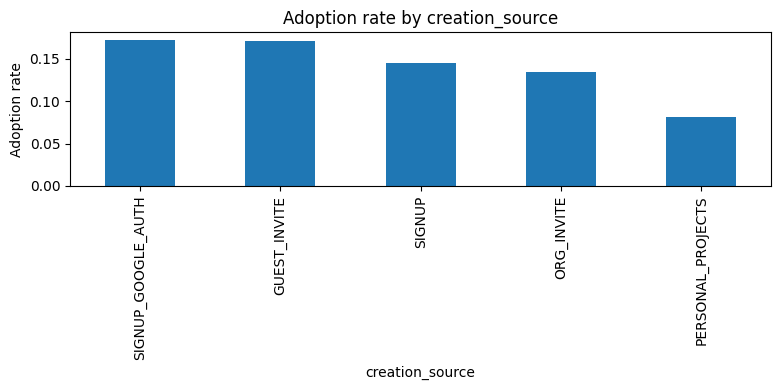

In [ ]:
# Optional bar plot
plt.figure(figsize=(8, 4))
adoption_by_source.plot(kind="bar")
plt.title("Adoption rate by creation_source")
plt.ylabel("Adoption rate")
plt.tight_layout()
plt.show()


Adoption rate by org size bucket:
org_size_bucket
small (<=5)      0.000000
medium (6-20)    0.169520
large (>20)      0.127619
Name: adopted_user, dtype: float64


/tmp/ipython-input-4149986626.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("org_size_bucket")["adopted_user"].mean().dropna()


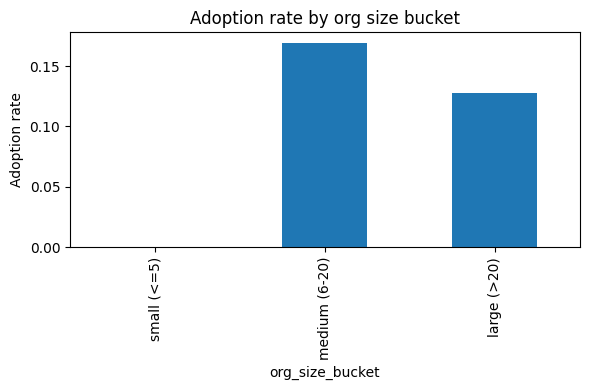

In [ ]:

# Adoption rate by org_size bucket (small/medium/large)
data["org_size_bucket"] = pd.cut(
    data["org_size"],
    bins=[0, 5, 20, np.inf],
    labels=["small (<=5)", "medium (6-20)", "large (>20)"],
    include_lowest=True
)
adoption_by_org_bucket = (
    data.groupby("org_size_bucket")["adopted_user"].mean().dropna()
)
print("\nAdoption rate by org size bucket:")
print(adoption_by_org_bucket)

plt.figure(figsize=(6, 4))
adoption_by_org_bucket.plot(kind="bar")
plt.title("Adoption rate by org size bucket")
plt.ylabel("Adoption rate")
plt.tight_layout()
plt.show()